In [1]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from numpy.ma.core import product
from sklearn.utils._repr_html import estimator

In [2]:
from lifelines import \
(KaplanMeierFitter ,
CoxPHFitter)
from lifelines.statistics import \
(logrank_test ,
multivariate_logrank_test)
from ISLP.survival import sim_time

# Brain Cancer Data

In [3]:
bcdf = load_data('BrainCancer')

In [4]:
bcdf

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30
...,...,...,...,...,...,...,...,...
83,Male,HG glioma,Supratentorial,80,0.16,SRT,1,20.69
84,Male,HG glioma,Supratentorial,80,19.81,SRT,1,6.39
85,Male,Meningioma,Supratentorial,90,2.50,SRT,0,32.82
86,Male,Meningioma,Supratentorial,90,2.02,SRS,0,42.07


# Definitions

$T$ - true *survival time*, the time at which the event of interest occurs, e.g. the time at which the patient dies, machine failure occurs, customer churns, etc.

$C$ - true *censoring time*, e.g. the time at which the patient drops out of the study, or the study ends.

We either observe the *survival* time, or the *censoring* time, or the random variable $Y$ defined as below:

$$Y = min(T, C)$$

We also observe a status indicator $\delta$:

$$
\delta =
\begin{cases}
1, & \text{if } T \le C \\[6pt]
0, & \text{if } T > C
\end{cases}
$$

# The Kaplan-Meier Survival Curve

$$S(t) = Pr(T > t)$$

This function quantifies the probability of surviving past time $t$.

Example: To estimate $S(20) =  Pr(T > 20)$, i.e. the probability  that a patient survives for at least $20$ months.

There are several ways to approach the problem:

1. The proportion of patients who are know to have survived past $20$ months, that is, the proportion of patients for whom $Y > 20$.

In [8]:
len(bcdf[bcdf['time'] > 20])

48

In [7]:
len(bcdf)

88

In [9]:
len(bcdf[bcdf['time'] > 20])/len(bcdf)

0.5454545454545454

but this does not seem quite right as $Y$ and $T$ represent different quantities.

In [10]:
len(bcdf[bcdf['time'] <= 20])

40

In [12]:
len(bcdf[(bcdf['status'] == 0) & (bcdf['time'] <= 20)])

17

In particular, $17$ of the $40$ patients who did not survive to $20$ months were actually censored, and this analysis implicitly assumes that $T <= 20$ for all of those censored patients, which in fact is unknown.

2. So, alternatively, to compute $S(20)$, we could consider computing the proportion of patients for whom $Y > 20$, out of $71$ ($88 -17$) who were not censored by the time $t = 20$, which is $48/71 \approx \%68$. But this is also problematic.

An approach to overcome these challenges:

$d_1 < d_2 < ... < d_K$ denote K unique death times among the non-censored patients, and let $q_k$ denote the number of patients who died at time $d_k$. For $k = 1,2,...,K$ let $r_k$ denote the number of alive patients just before $d_k$, these are the *at risk* patients.

By the Law of Probability,

$$S(d_k) = Pr(T > d_k) = Pr(T > d_k|T > d_{k−1})Pr(T > d_{k−1}) + Pr(T > d_k|T <= d_{k−1})Pr(T <= d_{k−1})$$

If a patient has not survived by time $d_{k-1}$, then it is impossible to survive past time $d_k$, and thus $Pr(T > d_k|T <= d_{k−1}) = 0$. Therefore, the above equation simplifies to:

$$S(d_k) = Pr(T > d_k) = Pr(T > d_k|T > d_{k−1})Pr(T > d_{k−1})$$

Plugging again,

$$S(d_k) = Pr(T > d_k|T > d_{k−1})S(d_{k−1})$$

This implies that,

$$S(d_k) = Pr(T > d_k|T > d_{k−1})Pr(T > d_{k−1}) \times ... \times Pr(T > d_2|T > d_1)Pr(T > d_1) $$

It is natural to use the estimator

$$Pr(T > d_j |T > d_{j −1}) = (rj − qj)/rj$$

which is the fraction of the risk set at time $d_j$ who survived past time $d_j$.
This leads to the *Kaplan–Meier* estimator of the survival curve:

$$\widehat{S}(d_k) = \prod_{j=1}^{k} \left( \frac{r_j - q_j}{r_j} \right)$$

For times $t$ between $d_k$ and $d_{k+1}$, we set $\widehat{S}(t) = \widehat{S}(d_k)$. Consequently, the
Kaplan–Meier survival curve has a step-like shape.



In [5]:
bcdf.sort_values(by=['time'], ascending=True)

,sex,diagnosis,loc,ki,gtv,stereo,status,time
27,Male,HG glioma,Supratentorial,70,33.69,SRT,1,0.07
82,Male,LG glioma,Infratentorial,90,30.41,SRT,0,1.18
48,Male,Meningioma,Supratentorial,70,0.97,SRT,1,1.41
79,Female,Meningioma,Infratentorial,70,2.94,SRS,0,1.54
40,Female,Meningioma,Supratentorial,80,1.57,SRT,0,2.03
...,...,...,...,...,...,...,...,...
29,Female,Meningioma,Supratentorial,90,4.72,SRS,0,65.02
63,Male,Meningioma,Supratentorial,80,4.77,SRT,0,67.38
76,Female,Meningioma,Supratentorial,80,2.39,SRS,0,73.74
64,Male,LG glioma,Supratentorial,80,9.58,SRT,0,78.75


In [15]:
len(bcdf[bcdf['status'] == 1])

35

So,
$$d_1 = 0.07, q_1 = 1, \text{and } r_1 = 88, (r_1 - q_1)/r_1 = 87/88 = 0.989$$

$$d_2 = 1.41, q_2 = 1, \text{and } r_2 = 86, (r_2 - q_2)/r_2 = 85/86 = 0.988$$

Now generalize,

In [6]:
 dlist = list(bcdf.loc[bcdf['status'] == 1, 'time'].sort_values())
 dlist

[0.07,
 1.41,
 3.38,
 4.16,
 4.56,
 6.1,
 6.23,
 6.3,
 6.39,
 6.82,
 6.92,
 7.05,
 7.25,
 8.98,
 9.77,
 10.82,
 11.02,
 11.57,
 14.0,
 14.62,
 16.43,
 16.92,
 19.9,
 20.69,
 22.03,
 25.02,
 29.7,
 31.15,
 31.25,
 33.41,
 35.93,
 39.54,
 46.16,
 47.8,
 51.02]

In [7]:
d2 = 1.41
q2 = len(bcdf[bcdf['time'] == d2])
print('q2 = ', q2)
r2 = len(bcdf[bcdf['time'] >= d2])
print('r2 = ', r2)

q2 =  1
r2 =  86


In [25]:
def compute_kaplan_meier_estimator(df):
    q = []
    r = []
    ei = []
    estimator = []
    dlist = list(df.loc[df['status'] == 1, 'time'].sort_values())
    for d in dlist:
        qi = len(df[df['time'] == d])
        q.append(qi)
        ri = len(df[df['time'] >= d])
        r.append(ri)
        ei.append((ri-qi)/ri)
    for i in range(len(ei)):
        p = 1
        for j in range(i):
            p *= ei[j]
        estimator.append(p)
    return q, r, estimator, dlist

In [26]:
q, r, p, dlist = compute_kaplan_meier_estimator(bcdf)

In [27]:
q

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1]

In [28]:
r

[88,
 86,
 83,
 82,
 81,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 70,
 69,
 68,
 65,
 64,
 61,
 59,
 57,
 55,
 54,
 49,
 47,
 46,
 43,
 40,
 38,
 37,
 32,
 28,
 25,
 18,
 16,
 13]

In [29]:
len(r)

35

In [30]:
len(q)

35

In [31]:
len(p)

35

In [32]:
p

[1,
 0.9886363636363636,
 0.9771405919661733,
 0.9653678137497134,
 0.9535950355332534,
 0.9418222573167935,
 0.9297476129922192,
 0.9176729686676449,
 0.9055983243430706,
 0.8935236800184964,
 0.8814490356939221,
 0.8693743913693478,
 0.8572997470447735,
 0.8450526078012768,
 0.83280546855778,
 0.8205583293142833,
 0.8079343550171405,
 0.7953103807199977,
 0.7822725056262272,
 0.769013649598664,
 0.7555221820618453,
 0.7417854151152663,
 0.7280486481686873,
 0.7131905124917753,
 0.6980162462685461,
 0.6828419800453168,
 0.6669619339977513,
 0.6502878856478075,
 0.6331750465518126,
 0.6160622074558176,
 0.5968102634728233,
 0.5754956112059367,
 0.5294559623094618,
 0.5000417421811584,
 0.46878913329483596]

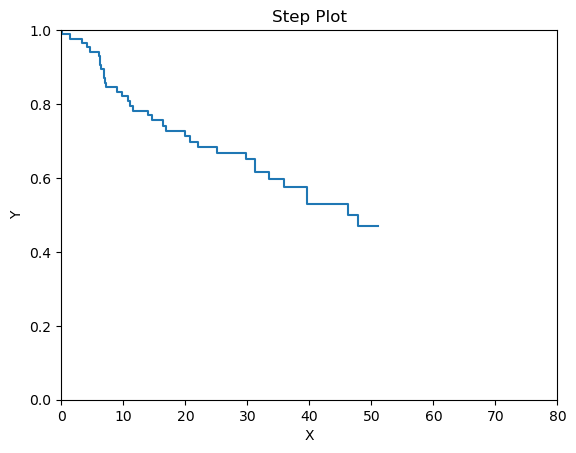

In [35]:
import matplotlib.pyplot as plt

x = dlist
y = p

plt.step(x, y, where='pre')   # or 'pre' or 'mid'
plt.xlim(0, 80)
plt.ylim(0, 1)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Step Plot")
plt.show()


In [33]:
[(i,v > 20) for i, v in enumerate(dlist)]

[(0, False),
 (1, False),
 (2, False),
 (3, False),
 (4, False),
 (5, False),
 (6, False),
 (7, False),
 (8, False),
 (9, False),
 (10, False),
 (11, False),
 (12, False),
 (13, False),
 (14, False),
 (15, False),
 (16, False),
 (17, False),
 (18, False),
 (19, False),
 (20, False),
 (21, False),
 (22, False),
 (23, True),
 (24, True),
 (25, True),
 (26, True),
 (27, True),
 (28, True),
 (29, True),
 (30, True),
 (31, True),
 (32, True),
 (33, True),
 (34, True)]

In [34]:
p[23]

0.7131905124917753

In [24]:
dlist

[0.07,
 1.41,
 3.38,
 4.16,
 4.56,
 6.1,
 6.23,
 6.3,
 6.39,
 6.82,
 6.92,
 7.05,
 7.25,
 8.98,
 9.77,
 10.82,
 11.02,
 11.57,
 14.0,
 14.62,
 16.43,
 16.92,
 19.9,
 20.69,
 22.03,
 25.02,
 29.7,
 31.15,
 31.25,
 33.41,
 35.93,
 39.54,
 46.16,
 47.8,
 51.02]

The estimated probability of survival past 20 months is $71\%$, which is quite a
bit higher than the naive estimates of $55\%$ and $68\%$ presented earlier.

# Lab

In [1]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data

In [2]:
from lifelines import (KaplanMeierFitter, CoxPHFitter)
from lifelines.statistics import (logrank_test, multivariate_logrank_test)
from ISLP.survival import sim_time

## Brain Cancer Data

In [3]:
bcdf = load_data('BrainCancer')
bcdf.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [4]:
bcdf

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30
...,...,...,...,...,...,...,...,...
83,Male,HG glioma,Supratentorial,80,0.16,SRT,1,20.69
84,Male,HG glioma,Supratentorial,80,19.81,SRT,1,6.39
85,Male,Meningioma,Supratentorial,90,2.50,SRT,0,32.82
86,Male,Meningioma,Supratentorial,90,2.02,SRS,0,42.07


In [5]:
bcdf['sex'].value_counts()

sex
Female    45
Male      43
Name: count, dtype: int64

In [6]:
bcdf['diagnosis'].value_counts()

diagnosis
Meningioma    42
HG glioma     22
Other         14
LG glioma      9
Name: count, dtype: int64

In [7]:
bcdf['status'].value_counts()

status
0    53
1    35
Name: count, dtype: int64

<Axes: xlabel='timeline'>

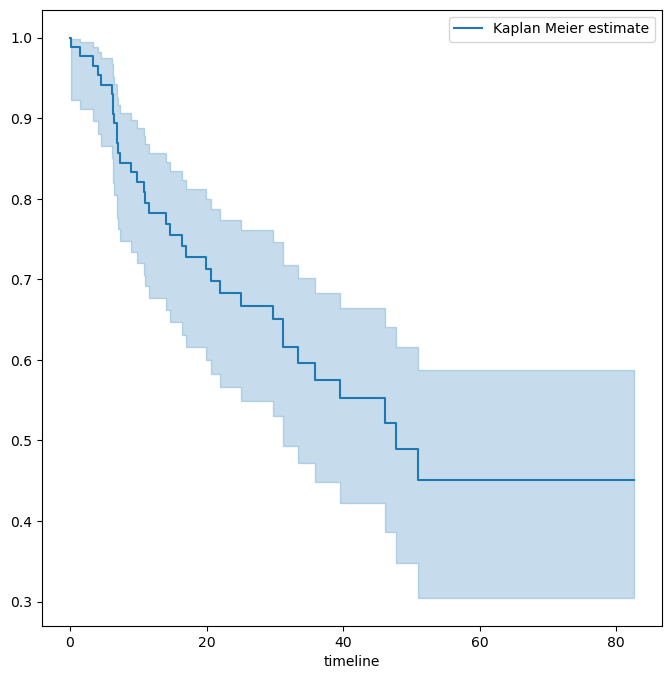

In [8]:
fig, ax = subplots(figsize=(8, 8))
km = KaplanMeierFitter()
km_brain = km.fit(bcdf['time'], bcdf['status'])
km_brain.plot(label='Kaplan Meier estimate',ax=ax)

In [16]:
for i in bcdf.groupby('sex'):
    print(i[0])

Female
Male


/tmp/ipykernel_22076/1598076775.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i in bcdf.groupby('sex'):


In [15]:
for i in bcdf.groupby('sex'):
    print(type(i[1]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


/tmp/ipykernel_22076/3788295085.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i in bcdf.groupby('sex'):


/tmp/ipykernel_22076/2665136319.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for sex, df in bcdf.groupby('sex'):


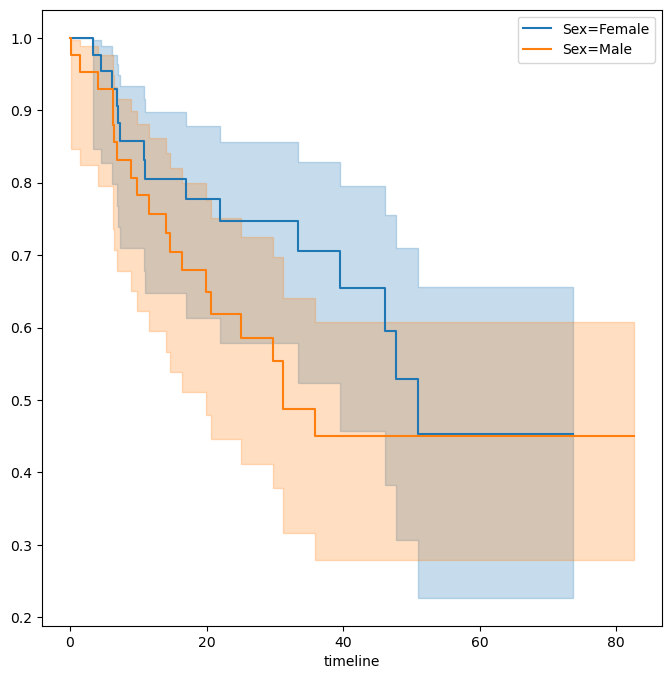

In [18]:
fig, ax = subplots(figsize=(8, 8))
by_sex = {}
for sex, df in bcdf.groupby('sex'):
    by_sex[sex] = df
    km_sex = km.fit(df['time'], df['status'])
    km_sex.plot(label=f'Sex={sex}', ax=ax)

In [19]:
logrank_test(by_sex['Male']['time'],
             by_sex['Female']['time'],
             by_sex['Male']['status'],
             by_sex['Female']['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

$p-value = 0.23$ indicates that there is no significant difference in survival time between males and females.